## Example study - 1
This jupyter notebook creates plots to study the impact of placing charging stations as per three scenarios: 

- **Scenario – 1: Attempt to reduce trip infeasibility**
- **Scenario – 2: Attempt to reduce charging sessions**
- **Scenario – 3: Attempt to reduce waiting sessions**


### 0. Analysis IDs to compare

In [2]:
# Define the set id for the analysis_ids that we want to compare
set_id  = (14, )

### 1. Package Installs

In [3]:
# python-dtenv to read the env variables
#!pip install python-dotenv

In [4]:
# Seaborn for plotting
#!pip install seaborn

In [5]:
# Plotly for plotting 
#!pip install plotly

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import os
import psycopg2
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px

### 2. Environment Variables

In [7]:
# Load the environment variables
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [8]:
# Print this to see if the env variables are read now
os.getenv("COMPOSE_PROJECT_NAME")

'evidss'

### 3. Database connection

In [9]:
# Generic function to test the connection to the database
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(    
            host=os.getenv("MAIN_HOST"),
            database=os.getenv("MAIN_DB"),
            user=os.getenv("DBREAD_USER"),
            password=os.getenv("DBREAD_PWD"), 
            port = os.getenv("MAIN_PORT")
        )
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [10]:
# Make the test database connection
connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 12.3 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',)
Database connection closed.


In [11]:
conn = psycopg2.connect(    
    host=os.getenv("MAIN_HOST"),
    database=os.getenv("MAIN_DB"),
    user=os.getenv("DBREAD_USER"),
    password=os.getenv("DBREAD_PWD"), 
    port = os.getenv("MAIN_PORT")
)

# create a cursor
cur = conn.cursor()

### 4. Database queries

In [12]:
cur.execute('select count(veh_id) from wa_bevs')
evs_in_wa = cur.fetchone()
evs_in_wa

(42995,)

In [13]:
sql_evs_in_sim = 'select count(veh_id), analysis_id from evtrip_scenarios where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_in_sim, (analysis_ids,))
evs_in_sim = pd.read_sql_query(sql=sql_evs_in_sim, con=conn, params=(set_id,))
evs_in_sim

,count,analysis_id
0,1240,302
1,1240,300
2,1229,301


In [14]:
sql_evs_fin = 'select count(veh_id), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_fin, (analysis_ids,))
evs_fin = pd.read_sql_query(sql=sql_evs_fin, con=conn, params=(set_id,))
evs_fin

,count,analysis_id
0,1236,302
1,1234,300
2,1225,301


In [15]:
sql_evs_str = 'select count(veh_id), analysis_id from ev_stranded where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_str, (analysis_ids,)) # Uncomment for debugging the query
evs_str = pd.read_sql_query(sql=sql_evs_str, con=conn, params=(set_id,))
evs_str

,count,analysis_id
0,4,302
1,4,301
2,6,300


In [16]:
sql_evs_str_loc = '''select stranded_lat, stranded_lng, est.analysis_id, coalesce(ne.count, 0) as nevse_count
from ev_stranded est
         left join (
    select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on est.analysis_id = ne.analysis_id
where est.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
ORDER BY nevse_count;'''
evs_str_loc = pd.read_sql_query(sql=sql_evs_str_loc, con=conn, params=(set_id,))
evs_str_loc.head()

,stranded_lat,stranded_lng,analysis_id,nevse_count
0,47.313240,-118.756601,302,10
1,47.040534,-124.033621,302,10
2,47.056000,-124.087512,302,10
3,47.377115,-122.976214,302,10
4,47.464594,-123.100285,300,10


In [17]:
sql_evmt = 'select sum(distance_travelled), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evmt, (analysis_ids,))
evmt = pd.read_sql_query(sql=sql_evmt, con=conn, params=(set_id,))
evmt

,sum,analysis_id
0,140262.0,302
1,142555.0,300
2,138302.0,301


In [18]:
sql_cs = 'select count(cs_id), analysis_id from evse_charging_session where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_cs, (analysis_ids,))
cs = pd.read_sql_query(sql=sql_cs, con=conn, params=(set_id,))
cs

,count,analysis_id
0,893,302
1,907,300
2,873,301


In [19]:
sql_ws = 'select count(wait_id), analysis_id from evse_evs_waiting where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_ws, (analysis_ids,))
ws = pd.read_sql_query(sql=sql_ws, con=conn, params=(set_id,))
ws

,count,analysis_id
0,499,302
1,499,300
2,493,301


In [54]:
basecase_aid = 295
sql_evse_util = """SELECT epd.analysis_id,
       epd.simulation_ts::timestamp as datetime,
       sum(epd.power_val)           as total_power,
       coalesce(ne.count, 0)               as nevse_count
FROM evse_power_draw epd
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on epd.analysis_id = ne.analysis_id
WHERE epd.analysis_id IN (select analysis_id from analysis_record where set_id IN %s UNION (select %s as analysis_id))
GROUP BY epd.simulation_ts, epd.analysis_id, nevse_count
ORDER BY nevse_count, epd.simulation_ts::timestamp;"""
# cur.mogrify(sql_evse_util, (analysis_ids,))
evse_util = pd.read_sql_query(sql=sql_evse_util, con=conn, params=(set_id,basecase_aid))
evse_util

,analysis_id,datetime,total_power,nevse_count
0,295,2019-07-01 08:00:46,0,0
1,295,2019-07-01 08:01:46,0,0
2,295,2019-07-01 08:02:46,0,0
3,295,2019-07-01 08:03:46,0,0
4,295,2019-07-01 08:04:46,0,0
...,...,...,...,...
3965,300,2019-07-02 01:49:46,0,10
3966,300,2019-07-02 01:50:46,0,10
3967,300,2019-07-02 01:51:46,0,10
3968,300,2019-07-02 01:52:46,0,10


In [21]:
sql_new_evses = """select latitude, longitude, analysis_id from new_evses 
                    where analysis_id IN 
                                (select analysis_id from analysis_record where set_id IN %s)"""
new_evses = pd.read_sql_query(sql=sql_new_evses, con=conn, params=(set_id,))
new_evses.head()

,latitude,longitude,analysis_id
0,47.975214,-119.900236,300
1,48.451066,-119.449602,300
2,46.890232,-119.416629,300
3,46.762443,-118.064729,300
4,47.798397,-120.988350,300


In [46]:
basecase_aid = 295
sql_count_stats = """select count(ets.veh_id) as sim_count,
       ets.analysis_id,
       coalesce(ne.count, 0) as nevse_count,
       ef.fin_count,
       ef.evmt,
       es.str_count,
       ecs.cs_count,
       ew.wait_count
from evtrip_scenarios ets
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on ets.analysis_id = ne.analysis_id
         join (select count(veh_id) as fin_count, sum(distance_travelled) as evmt, analysis_id
               from ev_finished
               group by analysis_id) as ef
              on ets.analysis_id = ef.analysis_id
         join (select count(veh_id) as str_count, analysis_id from ev_stranded group by analysis_id) as es
              on ets.analysis_id = es.analysis_id
         join (select count(cs_id) as cs_count, analysis_id from evse_charging_session group by analysis_id) as ecs
              on ets.analysis_id = ecs.analysis_id
join (select count(wait_id) as wait_count, analysis_id from evse_evs_waiting group by analysis_id) as ew
              on ets.analysis_id = ew.analysis_id
where ets.analysis_id IN (select analysis_id from analysis_record where set_id IN %s UNION (select %s as analysis_id))
group by ets.analysis_id, nevse_count, ef.fin_count, es.str_count, ef.evmt, ecs.cs_count, ew.wait_count
;"""
count_stats = pd.read_sql_query(sql=sql_count_stats, con=conn, params=(set_id,basecase_aid))
count_stats

,sim_count,analysis_id,nevse_count,fin_count,evmt,str_count,cs_count,wait_count
0,1204,295,0,1196,134677.0,8,812,443
1,1240,300,10,1234,142555.0,6,907,499
2,1229,301,10,1225,138302.0,4,873,493
3,1240,302,10,1236,140262.0,4,893,499


In [23]:
count_stats.dtypes
count_stats = count_stats.sort_values(by=['nevse_count'])
count_stats

,sim_count,analysis_id,nevse_count,fin_count,evmt,str_count,cs_count,wait_count
0,1240,300,10,1234,142555.0,6,907,499
1,1229,301,10,1225,138302.0,4,873,493
2,1240,302,10,1236,140262.0,4,893,499


In [24]:
sql_comp_stats = """select lai.action_tstamp_tx                                               as start_time,
       lau.aid,
       lau.action_tstamp_tx                                               as end_time_tripgen,
       las.action_tstamp_tx,
       '# EV: ' || es.ev_count as ev_count,
       coalesce(ne.count, 0) as nevse_count,
       ((DATE_PART('day', lau.action_tstamp_tx - lai.action_tstamp_tx) * 24 +
         DATE_PART('hour', lau.action_tstamp_tx - lai.action_tstamp_tx)) * 60 +
        DATE_PART('minute', lau.action_tstamp_tx - lai.action_tstamp_tx)) as time_taken_tripgen,
       ((DATE_PART('day', las.action_tstamp_tx - lau.action_tstamp_tx) * 24 +
         DATE_PART('hour', las.action_tstamp_tx - lau.action_tstamp_tx)) * 60 +
        DATE_PART('minute', las.action_tstamp_tx - lau.action_tstamp_tx)) as time_taken_eviabm
from audit.logged_actions lai
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'trips_generated') as lau
              on lau.aid = lai.row_data -> 'analysis_id'
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'solved') as las
              on las.aid = lai.row_data -> 'analysis_id'
         join (select count(veh_id) as ev_count, analysis_id from public.evtrip_scenarios group by analysis_id) as es
              on es.analysis_id = (lai.row_data -> 'analysis_id')::int
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on (lai.row_data -> 'analysis_id')::int = ne.analysis_id
where lai.action = 'I'
  and lai.row_data -> 'analysis_id' ~* (select string_agg(cast(analysis_id as text), '|') from analysis_record where set_id IN %s)
ORDER BY nevse_count
;"""
# data = '|'.join(map(str,set_id))
comp_stats = pd.read_sql_query(sql=sql_comp_stats, con=conn, params=(set_id,))
comp_stats

,start_time,aid,end_time_tripgen,action_tstamp_tx,ev_count,nevse_count,time_taken_tripgen,time_taken_eviabm
0,2020-11-30 20:34:02.396120+00:00,300,2020-11-30 20:49:20.184143+00:00,2020-11-30 23:51:45.954673+00:00,# EV: 1240,10,15.0,182.0
1,2020-11-30 20:45:15.217161+00:00,301,2020-11-30 20:58:40.676061+00:00,2020-12-01 00:01:26.594885+00:00,# EV: 1229,10,13.0,182.0
2,2020-11-30 20:56:08.990080+00:00,302,2020-11-30 21:08:22.647434+00:00,2020-12-01 00:01:49.174572+00:00,# EV: 1240,10,12.0,173.0


In [25]:
basecase_aid = 295 # basecase analysis_id used for CS and WS computation
sql_be_cs = """select count(cs_id) as count, analysis_id, evse_id, be.latitude, be.longitude
from evse_charging_session ecs
         left join built_evse be on
    'b' || cast(be.bevse_id as text) = substr(ecs.evse_id, 0, strpos(ecs.evse_id,'.0'))
where ecs.analysis_id = %s
group by ecs.analysis_id, ecs.evse_id, be.latitude, be.longitude
order by count desc
limit 10;
"""
be_cs = pd.read_sql_query(sql=sql_be_cs, con=conn, params=(basecase_aid,))
be_cs.head()

,count,analysis_id,evse_id,latitude,longitude
0,48,295,b124683.0,48.095461,-122.186896
1,42,295,b96282.0,47.568250,-122.667050
2,41,295,b96628.0,47.241980,-122.348098
3,41,295,b145684.0,47.998233,-122.100638
4,38,295,b73433.0,47.420940,-121.411300


In [26]:
sql_be_ws = """select count(wait_id) as count, analysis_id, evse_id, be.latitude, be.longitude
from evse_evs_waiting ews
         left join built_evse be on
    'b' || cast(be.bevse_id as text) = substr(ews.evse_id, 0, strpos(ews.evse_id,'.0'))
where ews.analysis_id = %s
group by ews.analysis_id, ews.evse_id, be.latitude, be.longitude
order by count desc
limit 10;
"""
be_ws = pd.read_sql_query(sql=sql_be_ws, con=conn, params=(basecase_aid,))
be_ws.head()

,count,analysis_id,evse_id,latitude,longitude
0,43,295,b124683.0,48.095461,-122.186896
1,38,295,b145684.0,47.998233,-122.100638
2,36,295,b96628.0,47.241980,-122.348098
3,35,295,b73433.0,47.420940,-121.411300
4,26,295,b95368.0,47.652505,-122.694367


In [81]:
sql_nevses_cs_count = """select ne.evse_id, coalesce(count(cs_id), 0) as count, ne.analysis_id
from (select 'n' || cast(nevse_id as text) as evse_id, analysis_id
      from new_evses
      where analysis_id IN (select analysis_id from analysis_record where set_id IN %s)) ne
       left join (select * from evse_charging_session) ecs
              on ecs.evse_id = ne.evse_id
group by ne.analysis_id, ne.evse_id;"""
nevses_cs_count = pd.read_sql_query(sql=sql_nevses_cs_count, con=conn, params=(set_id,))
nevses_cs_count.head()

,evse_id,count,analysis_id
0,n806,18,302
1,n787,1,300
2,n800,12,301
3,n803,8,301
4,n788,14,300


In [85]:
nevses_cs_count_300 = nevses_cs_count.loc[nevses_cs_count.analysis_id==300]
nevses_cs_count_300

,evse_id,count,analysis_id
1,n787,1,300
4,n788,14,300
6,n784,15,300
11,n790,0,300
15,n791,4,300
17,n793,4,300
18,n789,1,300
24,n792,0,300
28,n786,11,300
29,n785,5,300


In [86]:
nevses_cs_count_301 = nevses_cs_count.loc[nevses_cs_count.analysis_id==301]
nevses_cs_count_301

,evse_id,count,analysis_id
2,n800,12,301
3,n803,8,301
5,n801,60,301
8,n796,19,301
12,n798,22,301
14,n797,16,301
21,n794,29,301
22,n802,10,301
25,n795,38,301
26,n799,2,301


In [87]:
nevses_cs_count_302 = nevses_cs_count.loc[nevses_cs_count.analysis_id==302]
nevses_cs_count_302

,evse_id,count,analysis_id
0,n806,18,302
7,n808,5,302
9,n809,11,302
10,n812,22,302
13,n810,25,302
16,n811,5,302
19,n805,33,302
20,n813,31,302
23,n804,33,302
27,n807,16,302


### 5. Plotting

#### 5.1 Vehicle Counts

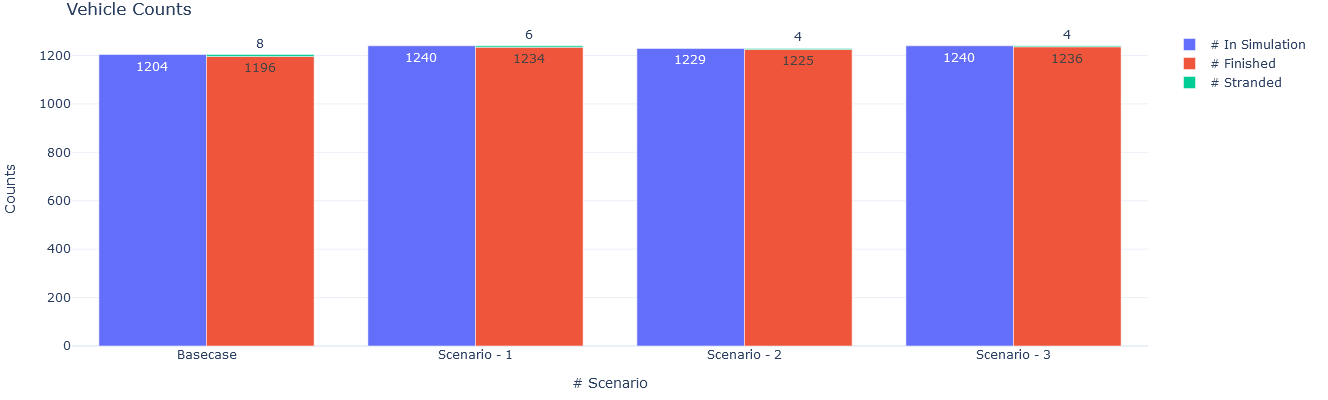

In [50]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# In Simulation",
            x=count_stats['analysis_id'],
            y=count_stats['sim_count'],
            offsetgroup=0,
            text=count_stats['sim_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Finished",
            x=count_stats['analysis_id'],
            y=count_stats['fin_count'],
            offsetgroup=1,
            text=count_stats['fin_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Stranded",
            x=count_stats['analysis_id'],
            y=count_stats['str_count'],
            offsetgroup=1,
            base=count_stats['fin_count'],
            text=count_stats['str_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Vehicle Counts",
        yaxis_title="Counts", 
        xaxis_title="# Scenario", width=600, height=400
        
    )
)
fig.update_xaxes(type='category', tickvals=[0, 1, 2, 3], ticktext=['Basecase', 'Scenario - 1', 'Scenario - 2', 'Scenario - 3'])
# fig.update_yaxes(range=(0, 1300))
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.2 eVMT

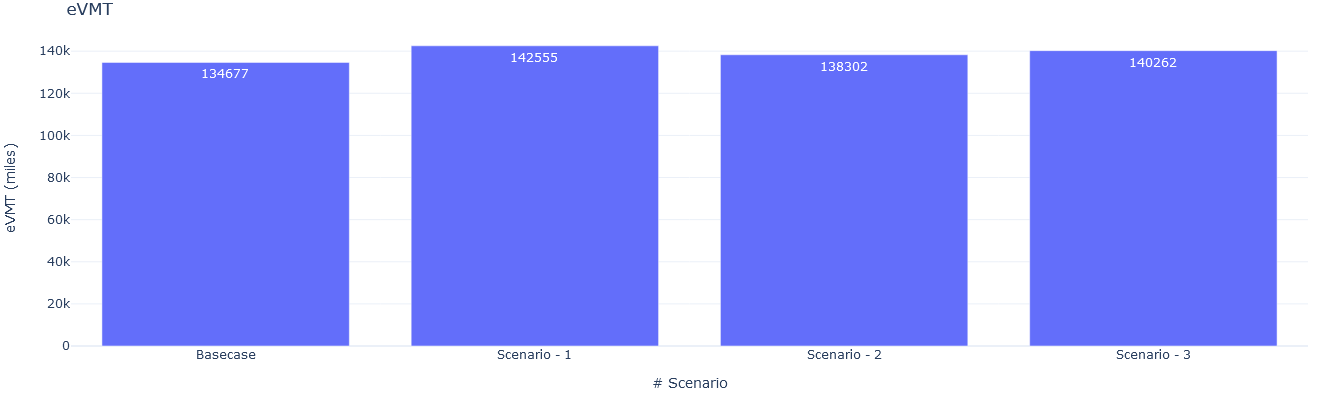

In [51]:
fig = go.Figure(
    data=[
        go.Bar(
            name="eVMT",
            x=count_stats['analysis_id'],
            y=count_stats['evmt'],
            offsetgroup=1,
            text=count_stats['evmt'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="eVMT",
        yaxis_title="eVMT (miles)", 
        xaxis_title="# Scenario", uniformtext_minsize=8, uniformtext_mode='hide', width=400, height=400
        
    )
)
fig.update_xaxes(type='category', tickvals=[0, 1, 2, 3], ticktext=['Basecase', 'Scenario - 1', 'Scenario - 2', 'Scenario - 3'])
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.3 Charging and Waiting Sessions

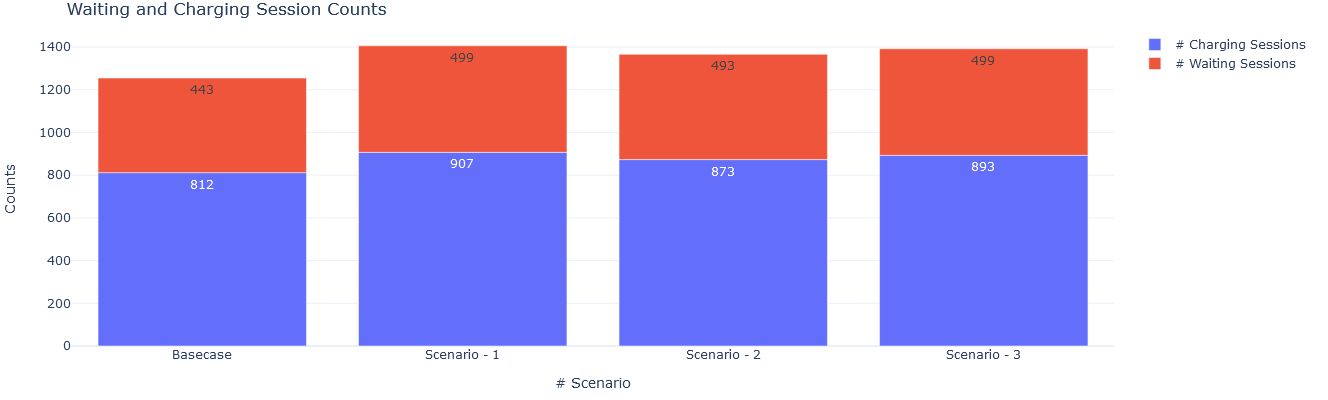

In [52]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# Charging Sessions",
            x=count_stats['analysis_id'],
            y=count_stats['cs_count'],
            offsetgroup=1,
            text=count_stats['cs_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Waiting Sessions",
            x=count_stats['analysis_id'],
            y=count_stats['wait_count'],
            offsetgroup=1,
            base=count_stats['cs_count'],
            text=count_stats['wait_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Waiting and Charging Session Counts",
        yaxis_title="Counts", 
        xaxis_title="# Scenario", width=600, height=400
        
    )
)
fig.update_xaxes(type='category', tickvals=[0, 1, 2, 3], ticktext=['Basecase', 'Scenario - 1', 'Scenario - 2', 'Scenario - 3'])
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.4 EVSE Utilization

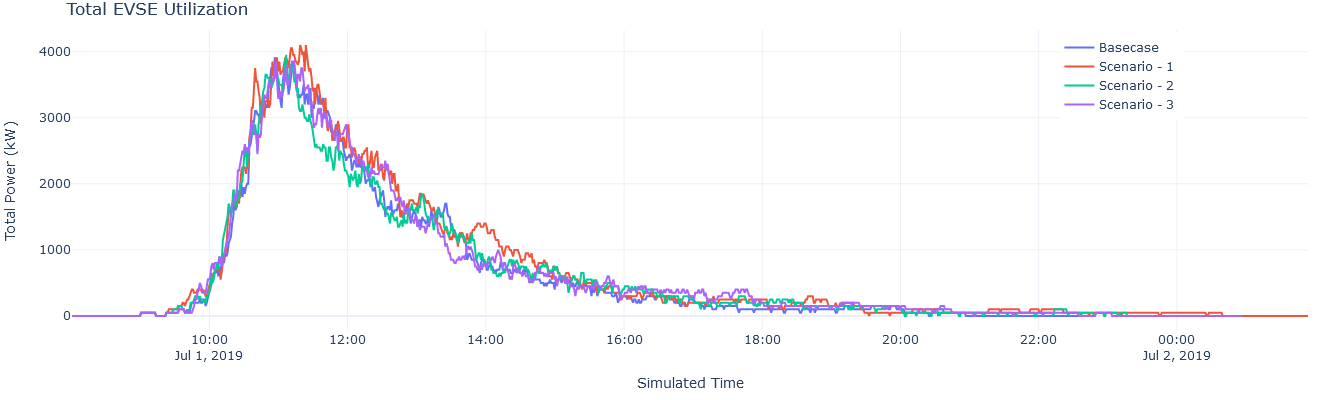

In [79]:
#fig = px.line(evse_util, x="datetime", y="total_power", color='analysis_id', name=['Basecase', 'Scenario - 1', 'Scenario - 2', 'Scenario - 3'], range_x=['2019-07-01 06:00','2019-07-02'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 295]['datetime'], y=evse_util[evse_util['analysis_id'] == 295]['total_power'],
                    mode='lines',
                    name='Basecase'))
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 300]['datetime'], y=evse_util[evse_util['analysis_id'] == 300]['total_power'],
                    mode='lines',
                    name='Scenario - 1'))
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 301]['datetime'], y=evse_util[evse_util['analysis_id'] == 301]['total_power'],
                    mode='lines',
                    name='Scenario - 2'))
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 302]['datetime'], y=evse_util[evse_util['analysis_id'] == 302]['total_power'],
                    mode='lines',
                    name='Scenario - 3'))

fig.update_layout(title="Total EVSE Utilization",
                  yaxis_title="Total Power (kW)", 
                  xaxis_title="Simulated Time", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=1000, 
                  height=400, 
                  margin=dict(l=20, r=20, t=30, b=20), template='plotly_white', showlegend=True, legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.9
))
fig.show()

In [31]:
token = os.getenv("MAPBOX_ACCESS_TOKEN")
analysis_ids = new_evses['analysis_id'].unique()

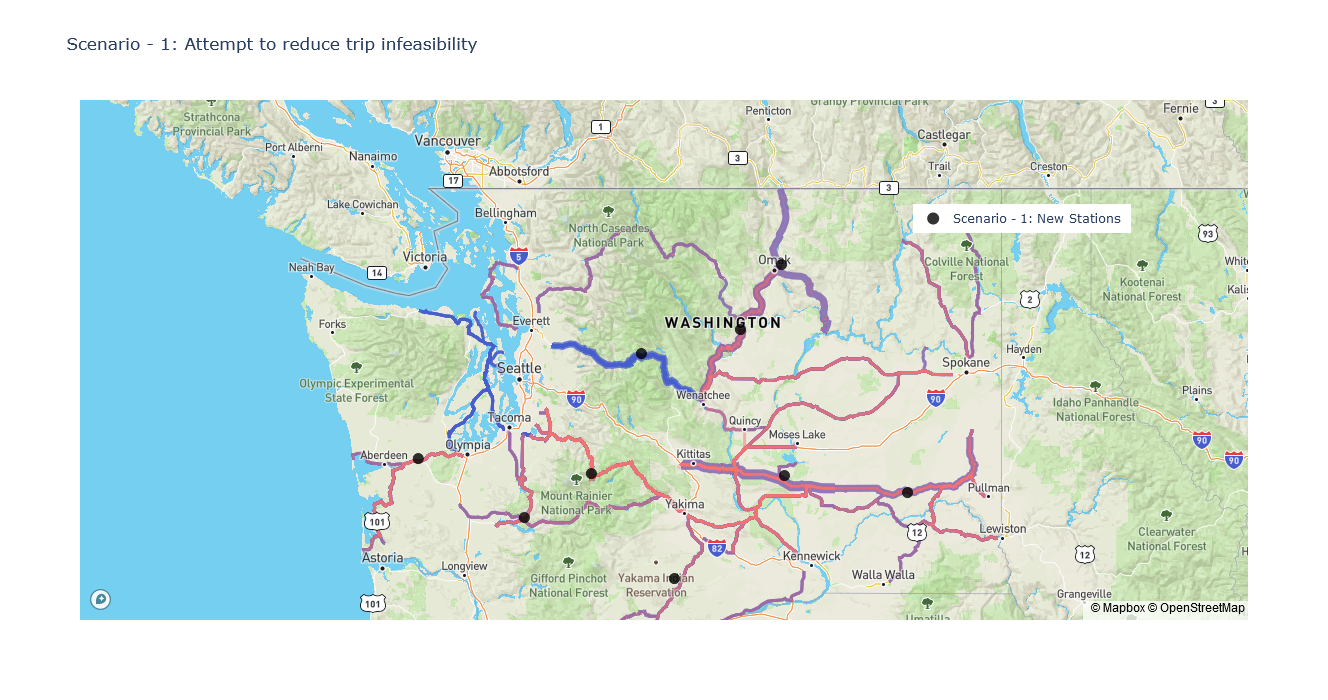

In [111]:
fig = go.Figure()
fig.add_trace(go.Scattermapbox(
        lat=new_evses[new_evses['analysis_id'] == analysis_ids[0]]['latitude'],
        lon=new_evses[new_evses['analysis_id'] == analysis_ids[0]]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color='rgb(0, 0, 0)',
            opacity=0.8
        ),
        hoverinfo='none', 
    name='Scenario - 1: New Stations'
    ))

fig.update_layout(
        title_text = 'Scenario - 1: Attempt to reduce trip infeasibility',
        showlegend = True,
        mapbox_style="mapbox://styles/chintanp/ckhmnh3oa01r419pkc9qgn0sq", mapbox_accesstoken=token,
        mapbox_zoom=6, mapbox_center = {"lat":  47.7511, "lon": -120.7401}, 
        width=1000, 
        height=700, legend=dict(
    yanchor="top",
    y=0.8,
    xanchor="right",
    x=0.9
)
    )

fig.show()

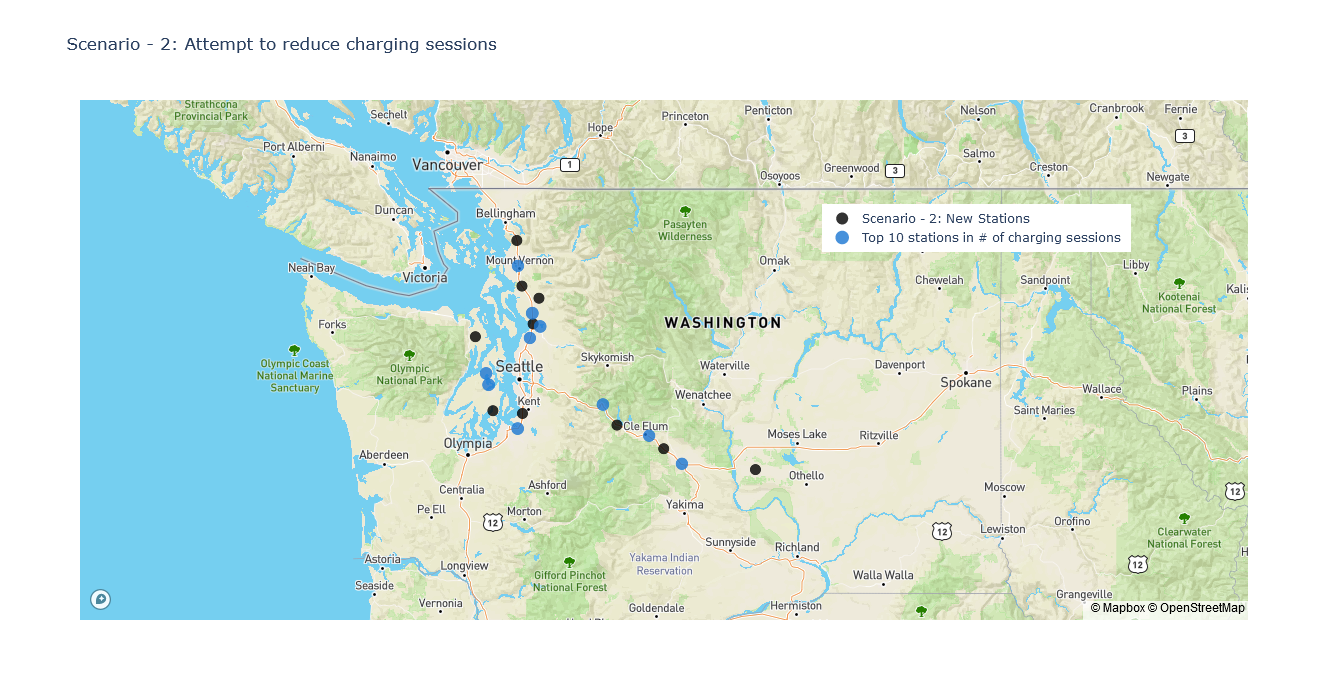

In [110]:
fig = go.Figure()
fig.add_trace(go.Scattermapbox(
        lat=new_evses[new_evses['analysis_id'] == analysis_ids[1]]['latitude'],
        lon=new_evses[new_evses['analysis_id'] == analysis_ids[1]]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color='rgb(0, 0, 0)',
            opacity=0.8
        ),
        hoverinfo='none', 
    name='Scenario - 2: New Stations'
    ))

fig.add_trace(go.Scattermapbox(
        lat=be_cs['latitude'],
        lon=be_cs['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10+np.log(be_cs['count']),
            color='#1976D2',
            opacity=0.8
        ),
        hoverinfo='none', 
    name='Top 10 stations in # of charging sessions'
    ))

fig.update_layout(
        title_text = 'Scenario - 2: Attempt to reduce charging sessions',
        showlegend = True,
        mapbox_style="streets", mapbox_accesstoken=token,
        mapbox_zoom=6, mapbox_center = {"lat":  47.7511, "lon": -120.7401}, 
        width=1000, 
        height=700, legend=dict(
    yanchor="top",
    y=0.8,
    xanchor="right",
    x=0.9
)
    )

fig.show()

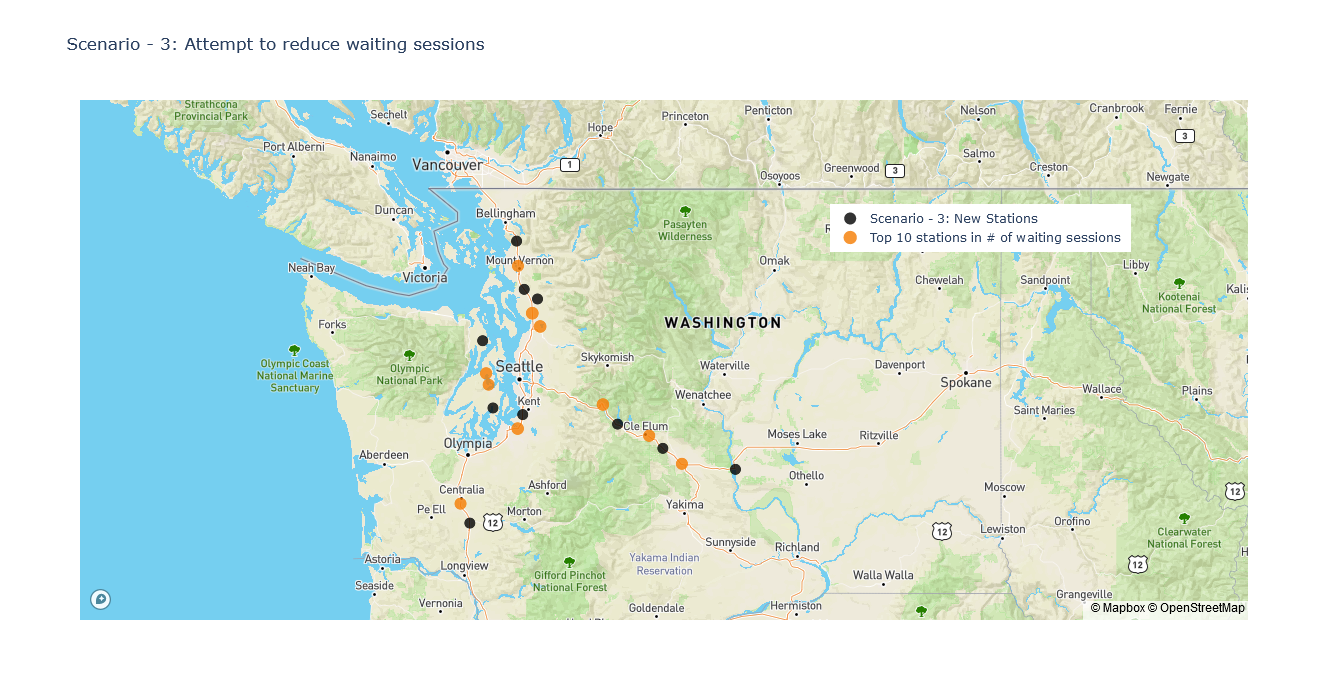

In [108]:
fig = go.Figure()
fig.add_trace(go.Scattermapbox(
        lat=new_evses[new_evses['analysis_id'] == analysis_ids[2]]['latitude'],
        lon=new_evses[new_evses['analysis_id'] == analysis_ids[2]]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color='rgb(0, 0, 0)',
            opacity=0.8
        ),
        hoverinfo='none', 
    name='Scenario - 3: New Stations'
    ))

fig.add_trace(go.Scattermapbox(
        lat=be_ws['latitude'],
        lon=be_ws['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10+np.log(be_ws['count']),
            color='#F57C00',
            opacity=0.8
        ),
        hoverinfo='none', 
    name='Top 10 stations in # of waiting sessions'
    ))

fig.update_layout(
        title_text = 'Scenario - 3: Attempt to reduce waiting sessions',
        showlegend = True,
        mapbox_style="streets", mapbox_accesstoken=token,
        mapbox_zoom=6, mapbox_center = {"lat":  47.7511, "lon": -120.7401}, 
        width=1000, 
        height=700, legend=dict(
    yanchor="top",
    y=0.8,
    xanchor="right",
    x=0.9
)
    )

fig.show()

In [92]:
sum(nevses_cs_count_300['count'])

55

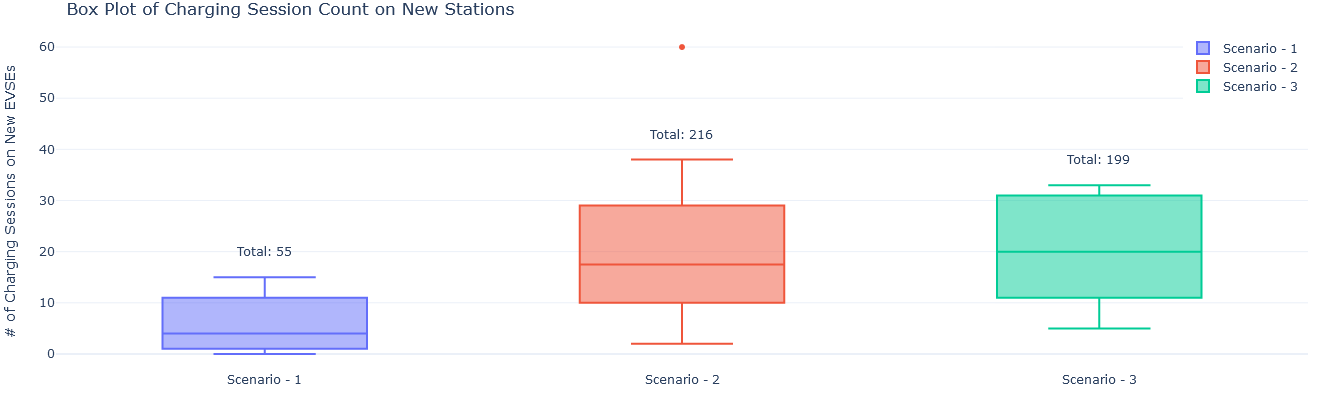

In [106]:
layout = go.Layout(
    annotations=go.Annotations([
        go.Annotation(
            x=0,
            y=20,
            text='Total: ' + str(sum(nevses_cs_count_300['count'])),
            showarrow=False,
            font=go.Font(
                size=12
            )
        ), go.Annotation(
            x=1,
            y=43,
            text='Total: ' + str(sum(nevses_cs_count_301['count'])),
            showarrow=False,
            font=go.Font(
                size=12
            )
        ), go.Annotation(
            x=2,
            y=38,
            text='Total: ' + str(sum(nevses_cs_count_302['count'])),
            showarrow=False,
            font=go.Font(
                size=12
            )
        )
    ])
)

fig = go.Figure(layout=layout)
fig.add_trace(go.Box(y=nevses_cs_count_300['count'], name = 'Scenario - 1', text = sum(nevses_cs_count_300['count'])))
fig.add_trace(go.Box(y=nevses_cs_count_301['count'], name = 'Scenario - 2'))
fig.add_trace(go.Box(y=nevses_cs_count_302['count'], name = 'Scenario - 3'))

fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', width=600, height=400, title="Box Plot of Charging Session Count on New Stations",
                  yaxis_title="# of Charging Sessions on New EVSEs", legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=1.0
))
fig.show()

____________
____________

Things to do the first time if the plotly plots not showing. Restart jupyter lab after. 

In [35]:
#!jupyter labextension list

In [36]:
#!jupyter labextension uninstall jupyterlab-plotly

In [37]:
#!jupyter labextension uninstall plotlywidget

In [38]:
#!export NODE_OPTIONS=--max-old-space-size=4096

In [39]:
#!pip show plotly

In [40]:
#!pip install jupyterlab "ipywidgets>=7.5"

In [41]:
#!jupyter labextension install jupyterlab-plotly@4.12.0

In [42]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.12.0

In [43]:
#!pip install "nbconvert<6"